In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime as dt
import os
import pickle
import scipy
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
sns.set_style('dark')
%matplotlib inline
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abhis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        stemmer = SnowballStemmer("english", ignore_stopwords=True)
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

In [3]:
# This function will provide result to our classification model
def validate_result(y_true, y_pred,y_prob,model="Model"):
    print(f"\nThe Result for the {model} Classification is as follows\n")
    print("=="*50)
    print(f"Recall Score: {(recall_score(y_true, y_pred,average='weighted')*100).round(3)} %")
    print(f"Precision Score: {(precision_score(y_true, y_pred,average='weighted')*100).round(3)} %")
    print("F1 Score: ",f1_score(y_true, y_pred,average='weighted').round(3))
    print("Log Loss: ",log_loss(y_true, y_prob).round(3))

In [4]:
data = pd.read_csv('./dataset/mozilla_bugs.csv')

In [5]:
data.head()

,Type,Summary,Product,Component,Priority,Classification,Team Name
0,defect,[trunk] Crash on startup (mozilla::ReadAheadLi...,Firefox,General,P1,Client Software,Frontend
1,defect,release-update-verify-config tasks failing for...,Release Engineering,Release Automation: Updates,P1,Other,RelEng
2,defect,Android workers not taking jobs.,Taskcluster,General,P1,Other,Mozilla
3,defect,browser/base/content/test/performance/browser_...,NSS,Libraries,P1,Components,Crypto
4,defect,Breakpoint positions are only fetched for some...,DevTools,Debugger,P1,Components,DevTools


In [7]:
data.shape #30000 records in total and 7 attributes

(30000, 7)

In [8]:
data.columns

Index(['Type', 'Summary', 'Product', 'Component', 'Priority', 'Classification',
       'Team Name'],
      dtype='object')

### Base Model Building And Prediction


#### Here we will use Naive Bayes for classification.

#### In addition to Team Name, we will also try to determine  Component and Classification based on the textual summary of the reported bug

#### We will create individual models for the same and test it out on Real World data for prediction

## Model Building using GaussianNB (with or without RandomizedSearch)

In [9]:
#Create Custom method for Model building (With or without Randomized Search)
def build_model(data,column_to_predict,classifier,use_random_search,remove_stop_words,stop_words_lang,use_stemming,fit_prior,min_data_per_class,text_columns):

    # Removing rows related to classes represented by low amount of data
    print("Shape of dataset before removing classes with less then " + str(min_data_per_class) + " rows: "+str(data.shape))
    print("Number of classes before removing classes with less then " + str(min_data_per_class) + " rows: "+str(len(np.unique(data[column_to_predict]))))
    bytag = data.groupby(column_to_predict).aggregate(np.count_nonzero)
    tags = bytag[bytag.Summary > min_data_per_class].index
    data = data[data[column_to_predict].isin(tags)]
    print(
            "Shape of dataset after removing classes with less then "
            + str(min_data_per_class) + " rows: "
            + str(data.shape)
        )
    print(
            "Number of classes after removing classes with less then "
            + str(min_data_per_class) + " rows: "
            + str(len(np.unique(data[column_to_predict])))
        )

    labelData = data[column_to_predict]
    data = data[text_columns]
    
    
    
    # Split dataset into training and testing data
    train_data, test_data, train_labels, test_labels = train_test_split(
        data, labelData, test_size=0.2
    )  # split data to train/test sets with 80:20 ratio

    # Extracting features from text
    # Count vectorizer
    if remove_stop_words:
        count_vect = CountVectorizer(stop_words=stop_words_lang)
    elif use_stemming:
        count_vect = StemmedCountVectorizer(stop_words=stop_words_lang)
    else:
        count_vect = CountVectorizer()

    # Fitting the training data into a data processing pipeline and eventually into the model itself
    if classifier == "NB":
        print("Training NB classifier")
        # Building a pipeline: We can write less code and do all of the above, by building a pipeline as follows:
        # The names ‘vect’ , ‘tfidf’ and ‘clf’ are arbitrary but will be used later.
        # We will be using the 'text_clf' going forward.

        text_clf = Pipeline([
            ('vect', count_vect),
            ('tfidf', TfidfTransformer()),
            ('clf', MultinomialNB(fit_prior=fit_prior))
        ])
        text_clf = text_clf.fit(train_data, train_labels)

    elif classifier == "SVM":
        print("Training SVM classifier")
        # Training Support Vector Machines - SVM
        text_clf = Pipeline([(
            'vect', count_vect),
            ('tfidf', TfidfTransformer()),
            ('clf', SGDClassifier(
                loss='hinge', penalty='l2', alpha=1e-3,
                n_iter_no_change=5, random_state=25
            )
        )])
        text_clf = text_clf.fit(train_data, train_labels)
        
        
        
    if use_random_search:
        # use_random_search
        # Here, we are creating a list of parameters for which we would like to do performance tuning.
        # All the parameters name start with the classifier name (remember the arbitrary name we gave).
        # E.g. vect__ngram_range; here we are telling to use unigram and bigrams and choose the one which is optimal.

        #NB parameters
        parameters = {
            'vect__ngram_range': [(1, 1), (1, 2)],
            'tfidf__use_idf': (True, False),
            'clf__alpha': (1e-2, 1e-3)
        }


        # Next, we create an instance of the grid search by passing the classifier, parameters
        # and n_jobs=-1 which tells to use multiple cores from user machine.
        rs_clf = RandomizedSearchCV(text_clf, parameters, n_jobs=-1, n_iter=10)
        rs_clf = rs_clf.fit(train_data, train_labels)

        # To see the best mean score and the params, run the following code
        print("Best Score:",rs_clf.best_score_)
        print("Best Params:", rs_clf.best_params_)
        print("Best Estimator:", rs_clf.best_estimator_)
        

    print("Evaluating model")
    # Score and evaluate model on test data using model without hyperparameter tuning
    predicted = text_clf.predict(test_data)
    prediction_acc = np.mean(predicted == test_labels)
    print("Confusion matrix without RandomizedSearch:")
    print(metrics.confusion_matrix(test_labels, predicted))
    print("Mean without RandomizedSearch: " + str(prediction_acc))
    
    
    # Score and evaluate model on test data using model WITH hyperparameter tuning
    if use_random_search:
        predicted = rs_clf.predict(test_data)
        prediction_acc = np.mean(predicted == test_labels)
        print("Confusion matrix with RandomizedSearch:")
        print(metrics.confusion_matrix(test_labels, predicted))
        print("Mean with RandomizedSearch: " + str(prediction_acc))
    
    validate_result(test_labels,text_clf.predict(test_data),text_clf.predict_proba(test_data),model="NB")
    # Ploting confusion matrix with 'seaborn' module

    mat = confusion_matrix(test_labels, predicted)
    plt.figure(figsize=(10, 10))
    sns.set()
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=np.unique(test_labels),
                yticklabels=np.unique(test_labels))
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    # Save confusion matrix to outputs folder
    # plt.savefig(os.path.join('.', 'outputs', 'confusion_matrix.png'))
    plt.show()
    
    
    # Printing classification report
    # Use below line only with Jupyter Notebook

    print(classification_report(test_labels, predicted,
                                target_names=np.unique(test_labels)))
    
    
    # Save trained models to /output folder
    if use_random_search:
        pickle.dump(
            rs_clf,
            open(os.path.join(
                '.', 'outputs', column_to_predict+"_NB_RS.model"),
                'wb'
            )
        )
    else:
        pickle.dump(
            text_clf,
            open(os.path.join(
                '.', 'outputs', column_to_predict+"_NB_RS.model"),
                'wb'
            )
        )


#### Build the model to predict Team Name

In [10]:
df2 = data.copy() #Keep a copy of original dataframe to ensure it can be used later. Dataframe data to be fed to the method

#Initialize parameters to be fed to the method for model building
column_to_predict = "Team Name"


classifier = "NB"  # Supported algorithms # "SVM" # "NB"
use_random_search = True  # grid search is used to find hyperparameters. Searching for hyperparameters is time consuming
remove_stop_words = False  # removes stop words from processed text
stop_words_lang = 'english'  # used with 'remove_stop_words' and defines language of stop words collection
use_stemming = True  # word stemming using nltk
fit_prior = True  # if use_stemming == True then it should be set to False ?? double check
min_data_per_class = 100  # used to determine number of samples required for each class.Classes with less than that will be excluded from the dataset. default value is 1


text_columns = "Summary" #text columns used for TF-IDF

Shape of dataset before removing classes with less then 100 rows: (30000, 7)
Number of classes before removing classes with less then 100 rows: 31
Shape of dataset after removing classes with less then 100 rows: (29848, 7)
Number of classes after removing classes with less then 100 rows: 27
Training NB classifier
Best Score: 0.6364855516675876
Best Params: {'vect__ngram_range': (1, 2), 'tfidf__use_idf': True, 'clf__alpha': 0.01}
Best Estimator: Pipeline(steps=[('vect',
                 StemmedCountVectorizer(ngram_range=(1, 2),
                                        stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB(alpha=0.01))])
Evaluating model
Confusion matrix without RandomizedSearch:
[[   0    0    0    0    0    0    0    2    0    0    1    0    0    0
    72    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    3    0    0    0    0    0    1    0    0    2    2    0    0
   160    0    0    0    2    

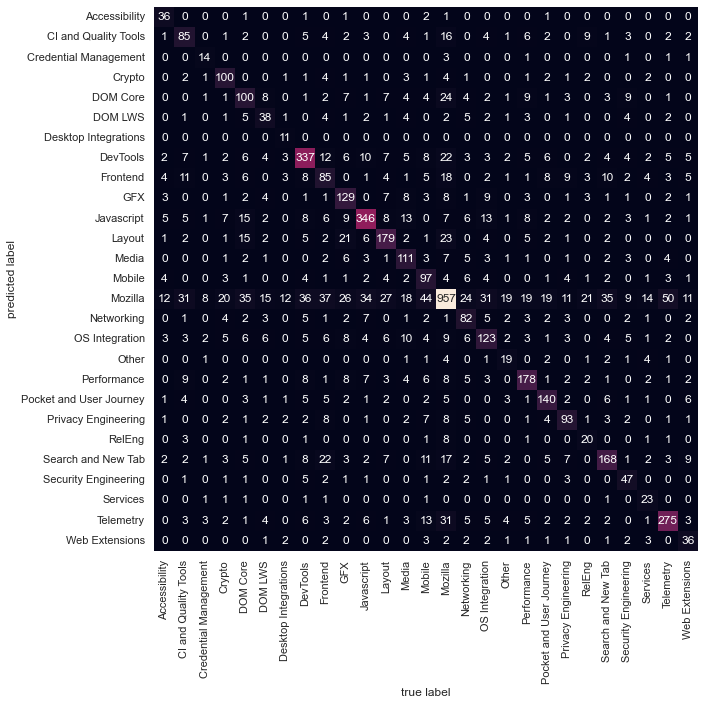

                         precision    recall  f1-score   support

          Accessibility       0.84      0.48      0.61        75
   CI and Quality Tools       0.55      0.50      0.52       170
  Credential Management       0.67      0.41      0.51        34
                 Crypto       0.78      0.62      0.69       161
               DOM Core       0.52      0.47      0.49       212
                DOM LWS       0.49      0.41      0.45        92
   Desktop Integrations       1.00      0.30      0.46        37
               DevTools       0.71      0.74      0.73       453
               Frontend       0.43      0.40      0.42       211
                    GFX       0.68      0.55      0.61       236
             Javascript       0.73      0.79      0.76       438
                 Layout       0.65      0.68      0.67       264
                  Media       0.71      0.57      0.63       196
                 Mobile       0.66      0.44      0.53       221
                Mozilla 

In [11]:
#Build Model
build_model(data, column_to_predict,classifier,use_random_search,remove_stop_words,stop_words_lang,use_stemming,fit_prior,min_data_per_class,text_columns)

In [12]:
#Load Model
model_Team_Name = pickle.load(
    open(
         os.getcwd()+"/outputs/Team Name_NB_RS.model", "rb"
    )
)

#### Build the Model to predict Component

In [13]:
data = df2.copy() #restore original dataframe which got modified while creating last model
#Initialize parameters to be fed to the method for model building
column_to_predict = "Component"


classifier = "NB"  # Supported algorithms # "SVM" # "NB"
use_random_search = True  # grid search is used to find hyperparameters. Searching for hyperparameters is time consuming
remove_stop_words = False  # removes stop words from processed text
stop_words_lang = 'english'  # used with 'remove_stop_words' and defines language of stop words collection
use_stemming = True  # word stemming using nltk
fit_prior = True  # if use_stemming == True then it should be set to False ?? double check
min_data_per_class = 50  # used to determine number of samples required for each class.Classes with less than that will be excluded from the dataset. default value is 1


text_columns = "Summary" #text columns used for TF-IDF

Shape of dataset before removing classes with less then 50 rows: (30000, 7)
Number of classes before removing classes with less then 50 rows: 536
Shape of dataset after removing classes with less then 50 rows: (24724, 7)
Number of classes after removing classes with less then 50 rows: 126
Training NB classifier
Best Score: 0.5232822488588122
Best Params: {'vect__ngram_range': (1, 2), 'tfidf__use_idf': True, 'clf__alpha': 0.001}
Best Estimator: Pipeline(steps=[('vect',
                 StemmedCountVectorizer(ngram_range=(1, 2),
                                        stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB(alpha=0.001))])
Evaluating model
Confusion matrix without RandomizedSearch:
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0  14 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0 142]]
Mean without RandomizedSearch: 0.22649140546006066

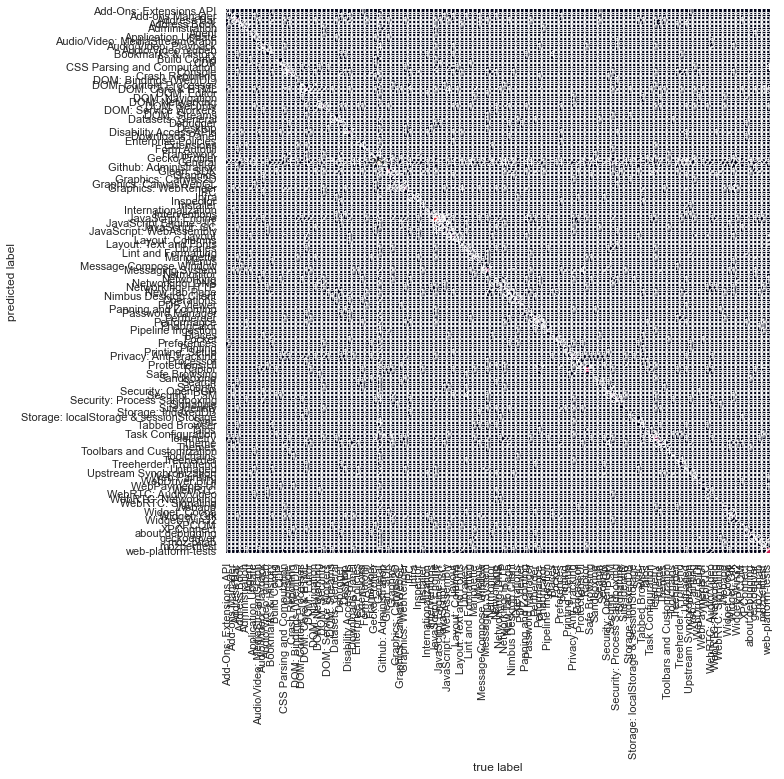

                                        precision    recall  f1-score   support

               Add-Ons: Extensions API       0.36      0.36      0.36        11
                       Add-ons Manager       0.29      0.18      0.22        22
                           Address Bar       0.62      0.69      0.66        88
                          Address Book       0.56      0.77      0.65        13
                        Administration       0.74      0.53      0.62        32
                                 Agent       0.86      0.44      0.58        43
                    Application Update       0.77      0.53      0.62        19
         Audio/Video: MediaStreamGraph       0.60      0.30      0.40        10
                 Audio/Video: Playback       0.71      0.55      0.62        64
                    Audio/Video: cubeb       0.93      0.67      0.78        21
                   Bookmarks & History       0.31      0.23      0.26        22
                          Build Config 

In [14]:
#Build Model
build_model(data, column_to_predict,classifier,use_random_search,remove_stop_words,stop_words_lang,use_stemming,fit_prior,min_data_per_class,text_columns)

In [15]:
#Load Model
model_Component = pickle.load(
    open(
         os.getcwd()+"/outputs/Component_NB_RS.model", "rb"
    )
)

#### Build Model to predict Classification

In [16]:
data = df2.copy() #restore original dataframe which got modified while creating last model
#Initialize parameters to be fed to the method for model building
column_to_predict = "Classification"


classifier = "NB"  # Supported algorithms # "SVM" # "NB"
use_random_search = True  # grid search is used to find hyperparameters. Searching for hyperparameters is time consuming
remove_stop_words = False  # removes stop words from processed text
stop_words_lang = 'english'  # used with 'remove_stop_words' and defines language of stop words collection
use_stemming = True  # word stemming using nltk
fit_prior = True  # if use_stemming == True then it should be set to False ?? double check
min_data_per_class = 10  # used to determine number of samples required for each class.Classes with less than that will be excluded from the dataset. default value is 1


text_columns = "Summary" #text columns used for TF-IDF

Shape of dataset before removing classes with less then 10 rows: (30000, 7)
Number of classes before removing classes with less then 10 rows: 5
Shape of dataset after removing classes with less then 10 rows: (30000, 7)
Number of classes after removing classes with less then 10 rows: 5
Training NB classifier
Best Score: 0.8245833333333333
Best Params: {'vect__ngram_range': (1, 2), 'tfidf__use_idf': False, 'clf__alpha': 0.01}
Best Estimator: Pipeline(steps=[('vect',
                 StemmedCountVectorizer(ngram_range=(1, 2),
                                        stop_words='english')),
                ('tfidf', TfidfTransformer(use_idf=False)),
                ('clf', MultinomialNB(alpha=0.01))])
Evaluating model
Confusion matrix without RandomizedSearch:
[[ 639  845    0    0    1]
 [  62 3733    0    0    0]
 [  32  371   23    0    0]
 [  28  115    0    0    0]
 [  16  102    0    0   33]]
Mean without RandomizedSearch: 0.738
Confusion matrix with RandomizedSearch:
[[1103  354   18

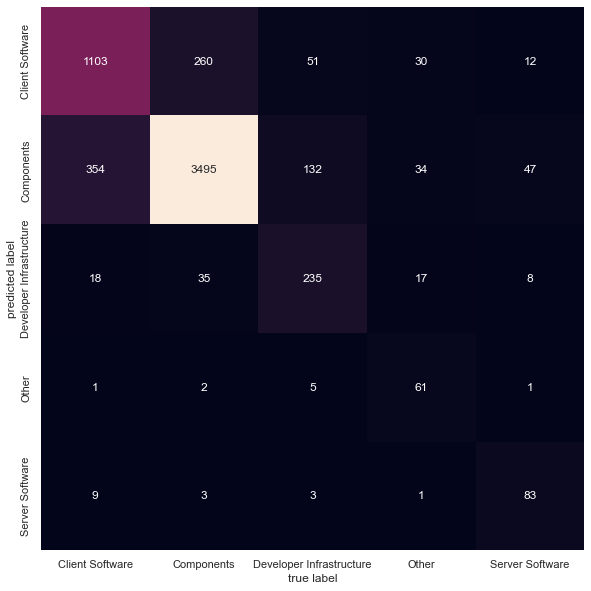

                          precision    recall  f1-score   support

         Client Software       0.76      0.74      0.75      1485
              Components       0.86      0.92      0.89      3795
Developer Infrastructure       0.75      0.55      0.64       426
                   Other       0.87      0.43      0.57       143
         Server Software       0.84      0.55      0.66       151

                accuracy                           0.83      6000
               macro avg       0.82      0.64      0.70      6000
            weighted avg       0.83      0.83      0.82      6000



In [17]:
#Build Model
build_model(data, column_to_predict,classifier,use_random_search,remove_stop_words,stop_words_lang,use_stemming,fit_prior,min_data_per_class,text_columns)

In [18]:
#Load Model
model_Classification = pickle.load(
    open(
         os.getcwd()+"/outputs/Classification_NB_RS.model", "rb"
    )
)

#### Feed Random problem summary of support tickets to test predictions by the pre-trained models.

In [19]:
#Random sample input texts 'summarizing the issue' and fed to the models for testing
description1='Sync error while signing in to profile'
description2='details not appearing on locked device'
description3='Crash on toggle of settings on iPad'
description4='Unable to save credentials for email'
description5='Browser keeps crashing on opening multiple tabs' 
description6='Themes resulting in modified colors on the menubar'

In [20]:
#Team Name Model
predicted = model_Team_Name.predict([description1])
print("Predicted Team Name: " + str(predicted))
predicted = model_Team_Name.predict([description2])
print("Predicted Team Name: " + str(predicted))
predicted = model_Team_Name.predict([description3])
print("Predicted Team Name: " + str(predicted))
predicted = model_Team_Name.predict([description4])
print("Predicted Team Name: " + str(predicted))
predicted = model_Team_Name.predict([description5])
print("Predicted Team Name: " + str(predicted))
predicted = model_Team_Name.predict([description6])
print("Predicted Team Name: " + str(predicted))

Predicted Team Name: ['Mozilla']
Predicted Team Name: ['Mozilla']
Predicted Team Name: ['Mobile']
Predicted Team Name: ['Mozilla']
Predicted Team Name: ['Frontend']
Predicted Team Name: ['Search and New Tab']


In [21]:
#Component Model
predicted = model_Component.predict([description1])
print("Predicted Component: " + str(predicted))
predicted = model_Component.predict([description2])
print("Predicted Component: " + str(predicted))
predicted = model_Component.predict([description3])
print("Predicted Component: " + str(predicted))
predicted = model_Component.predict([description4])
print("Predicted Component: " + str(predicted))
predicted = model_Component.predict([description5])
print("Predicted Component: " + str(predicted))
predicted = model_Component.predict([description6])
print("Predicted Component: " + str(predicted))

Predicted Component: ['General']
Predicted Component: ['General']
Predicted Component: ['General']
Predicted Component: ['Untriaged']
Predicted Component: ['General']
Predicted Component: ['Widget: Cocoa']


In [22]:
#Classification Model
predicted = model_Classification.predict([description1])
print("Predicted Classification: " + str(predicted))
predicted = model_Classification.predict([description2])
print("Predicted Classification: " + str(predicted))
predicted = model_Classification.predict([description3])
print("Predicted Classification: " + str(predicted))
predicted = model_Classification.predict([description4])
print("Predicted Classification: " + str(predicted))
predicted = model_Classification.predict([description5])
print("Predicted Classification: " + str(predicted))
predicted = model_Classification.predict([description6])
print("Predicted Classification: " + str(predicted))

Predicted Classification: ['Client Software']
Predicted Classification: ['Components']
Predicted Classification: ['Client Software']
Predicted Classification: ['Components']
Predicted Classification: ['Client Software']
Predicted Classification: ['Client Software']
